In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Задание

Даны две выгрузки:

    - Платежи за  период Payments.csv
    - Пользователи за этот же период Users.csv

[Какие метрики можно рассчитать?](#ans)

[Какие сегменты вы бы выделили?](#ans)

Возьмите данную выгрузку и сделайте следующее:

* [Распределите IAP по кол-ву (шт.)  и по доходам (в USD), которые они принесли](#iap)
* [Распределите доход от данной когорты по уровню игроков](#rev)

# Решение 

## Загрузка данных

Загрузим данные и посмотрим, что в них содержится

In [2]:
payments_data = pd.read_csv('Payments.csv')

In [3]:
payments_data.head()

,User_ID,Date,Level,Transaction_name,Amount_in_usd
0,853904,2018-11-28 15:44:18,10,pack11,5.069
1,1334215,2018-11-28 20:21:39,18,usd4,3.990
2,1248300,2018-11-28 21:53:49,10,pack11,4.990
3,26280,2018-11-29 02:26:19,34,usd50,49.990
4,74660,2018-11-28 01:58:44,6,usd10,9.990


In [4]:
payments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           4835 non-null   int64  
 1   Date              4835 non-null   object 
 2   Level             4835 non-null   int64  
 3   Transaction_name  4835 non-null   object 
 4   Amount_in_usd     4835 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 189.0+ KB


В данных платежей содержатся:

    - User_ID - идентификатор пользователя
    - Date - дата платежа (формат дата-время)
    - Level - уровень пользователя
    - Transaction_name - название проданного товара
    - Amount_in_usd - стоимость покупки в долларах
    
 Незаполненных данных нет

In [5]:
users_data = pd.read_csv('Users.csv')

In [6]:
users_data.head()

,User_ID,Created,Paying,Tester,Level,Country,Channel
0,1053809,2018-08-06 19:50:54,False,False,11,US,Organic
1,1238127,2018-10-27 15:13:14,True,False,17,RU,Organic
2,1298955,2018-11-18 04:22:40,False,False,1,CN,Organic
3,1288864,2018-11-16 00:54:20,False,False,9,US,Facebook Ads
4,1198466,2018-10-03 06:29:24,False,False,7,US,unityads_int


In [7]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27205 entries, 0 to 27204
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   User_ID  27205 non-null  int64 
 1   Created  27205 non-null  object
 2   Paying   27205 non-null  bool  
 3   Tester   27205 non-null  bool  
 4   Level    27205 non-null  int64 
 5   Country  27101 non-null  object
 6   Channel  27205 non-null  object
dtypes: bool(2), int64(2), object(3)
memory usage: 1.1+ MB


В данных пользователей содержатся:

    - User_ID - идентификатор пользователя
    - Created - дата регистрации (формат дата-время)
    - Paying - признак того, что пользователь плательшик
    - Tester - признак того, является ли пользователь тестером
    - Level - уровень пользователя
    - Country - страна пользователя
    - Channel - откуда пришел пользователь
    
Для некоторых пользователей нет данных по стране

## Подготовка данных

Так как среди наших пользователей могут быть тестеры, исключим их покупки, если они есть. Также добавим разобьем уровни пользователей на группы и добавим к данным покупок группу уровней пользователя. И страну из таблицы users. Это нужно для того, чтобы предоставить графики доходов по странам и по группам уровней

Посмотрим какие уровни есть у пользователей

In [8]:
print('Минимальный уровень', min(payments_data.Level))
print('Максимальный уровень', max(payments_data.Level))

Минимальный уровень 1
Максимальный уровень 56


Сформируем таблицу с данными пользователей (id, страна), исключив тестеров

In [9]:
users_data_for_join = users_data.loc[users_data['Tester'] == False, ['User_ID', 'Country']]

In [10]:
payments_data = payments_data.merge(users_data_for_join, how = 'inner', on = 'User_ID', suffixes = ('_payment', '_user'))

In [11]:
payments_data.head()

,User_ID,Date,Level,Transaction_name,Amount_in_usd,Country
0,853904,2018-11-28 15:44:18,10,pack11,5.069,AU
1,1334215,2018-11-28 20:21:39,18,usd4,3.990,US
2,1334215,2018-12-02 02:54:32,20,usd4,3.990,US
3,1334215,2018-12-04 04:58:32,21,usd4,3.990,US
4,1334215,2018-11-22 07:37:38,6,usd4,3.990,US


In [12]:
payments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4831 entries, 0 to 4830
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           4831 non-null   int64  
 1   Date              4831 non-null   object 
 2   Level             4831 non-null   int64  
 3   Transaction_name  4831 non-null   object 
 4   Amount_in_usd     4831 non-null   float64
 5   Country           4821 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 264.2+ KB


## Ответы на вопросы 

<a id='ans'> </a>  
* Какие метрики можно рассчитать?

    По платежам можно рассчитать метрики ARPU, ARPPU, ARPDAU и выручку с платежей в целом.
    

* Какие сегменты вы бы выделили?

    Проанализировать доход можно по:

    - Уровням пользователей.
      Но не по каждому уровню, а например разбив по группам уровней. Например на уровни 1-7, 8-20, 21 и более
    - Странам пользователей
    - Каналам привлечения
    - Проданным товарам

## Распределение IAP <a id='iap'> </a>

### Доход и кол-во проданных товаров

Для начала посмотрим как распределялись купленные товары по кол-ву и выручке. Под купленным товаром подразумевается значение в колонке `Transaction_name`

In [13]:
rows_list = []

for product in payments_data.Transaction_name.unique():
    product_count = len(payments_data[payments_data['Transaction_name'] == product])
    product_revenue = sum(payments_data[payments_data['Transaction_name'] == product].Amount_in_usd)
    rows_list.append({'Product':product, 'Count':product_count, 'Amount':product_revenue})

products_revenue = pd.DataFrame(rows_list)

In [14]:
print('Кол-во продуктов = ', len(products_revenue))

Кол-во продуктов =  63


Так как продуктов много, выведем только 10 продуктов, приносящих существенный доход

In [15]:
largest_revenues = products_revenue.nlargest(10, ['Amount'])

In [16]:
largest_revenues.head()

,Product,Count,Amount
0,pack11,357,597039510.847
3,usd10,505,74212765.826
25,usd75,126,9655.112
15,usd25,225,5809.884
5,pack13,182,3612.614


Так как есть большой разброс в выручке по продуктам pack11 и usd10, выведем графики по ним отдельно

In [17]:
sns.set(rc={'figure.figsize':(10,5)})

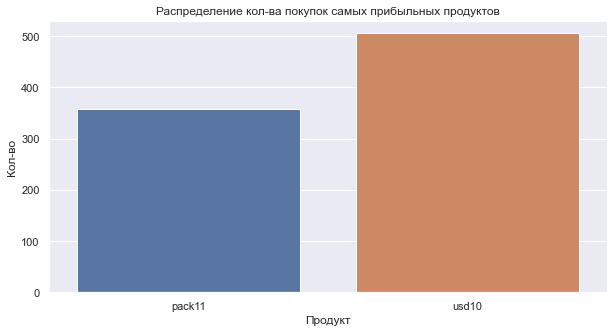

In [18]:
ax1 = sns.barplot(x="Product", y="Count", data=largest_revenues[:2])
ax1.set(xlabel='Продукт', ylabel='Кол-во', title = 'Распределение кол-ва покупок самых прибыльных продуктов');

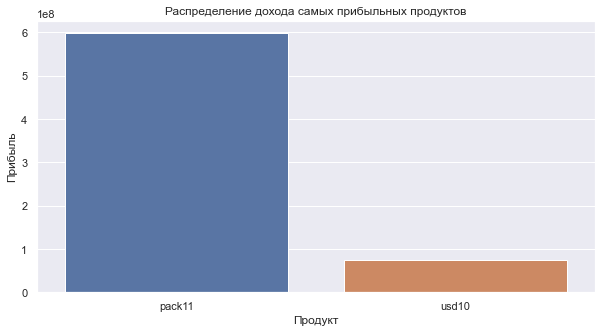

In [19]:
ax2 = sns.barplot(x = "Product", y = "Amount", data=largest_revenues[:2])
ax2.set(xlabel = 'Продукт', ylabel = 'Прибыль', title = 'Распределение дохода самых прибыльных продуктов');

Выведем графики по остальным продуктам

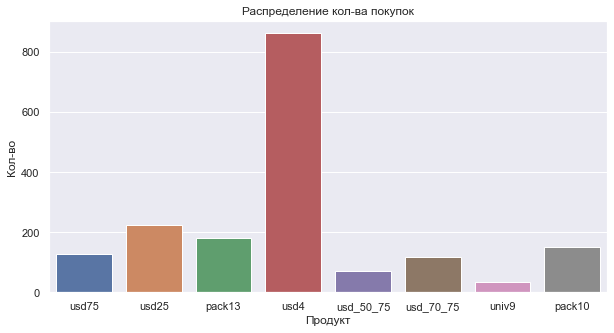

In [20]:
ax1 = sns.barplot(x="Product", y="Count", data=largest_revenues[2:])
ax1.set(xlabel='Продукт', ylabel='Кол-во', title = 'Распределение кол-ва покупок');

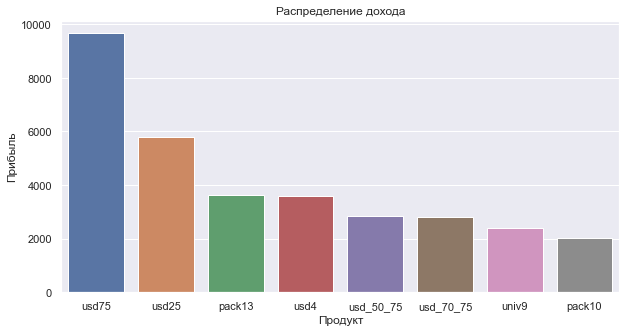

In [21]:
ax2 = sns.barplot(x = "Product", y = "Amount", data=largest_revenues[2:])
ax2.set(xlabel = 'Продукт', ylabel = 'Прибыль', title = 'Распределение дохода');

## Доход по уровням игроков <a id='rev'> </a>

Сгруппируем данные по доходу в разрезе групп уровней.

In [22]:
payments_by_level = payments_data.loc[:,['Level', 'Amount_in_usd']].groupby(by = 'Level', as_index=False).sum('Amount_in_usd')

Построим график распределения доходов по группам уровней игроков

In [23]:
payments_by_level.head()

,Level,Amount_in_usd
0,1,407.766
1,2,28.365
2,3,2006.517
3,4,552.286
4,5,2219.459


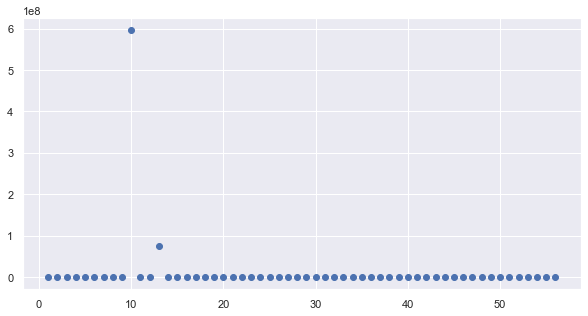

In [24]:
plt.plot(payments_by_level.Level, payments_by_level.Amount_in_usd, linestyle = 'None', marker="o");

Два показателя дохода по уровням являются сильно выделяются (outliers). Найдем их 

In [25]:
payments_by_level.nlargest(2, columns = 'Amount_in_usd')

,Level,Amount_in_usd
9,10,597041443.887
12,13,74208878.853


Удалим их и перестоим график по остальным

In [26]:
payments_without_outliers = payments_by_level[~payments_by_level.Level.isin([10, 13])]

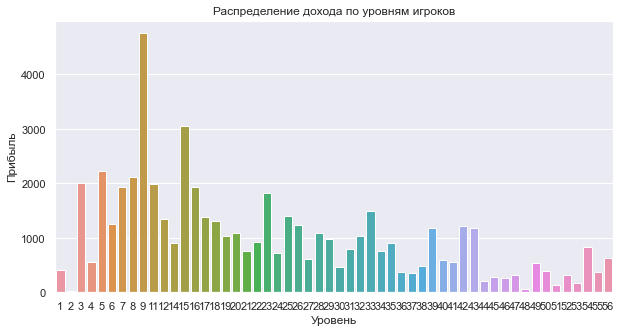

In [27]:
ax3 = sns.barplot(x = "Level", y = "Amount_in_usd", data = payments_without_outliers)
ax3.set(xlabel = 'Уровень', ylabel = 'Прибыль', title = 'Распределение дохода по уровням игроков')
sns.set(rc={'figure.figsize':(20,10)});